## Setup, Loading Data and CDFs

In [2]:
DATA_NAME = 'approx1e5-pastis-wavelet-gray' # size-name-transform-channel

In [ ]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = True
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/wavelet/approx1e5/gray'

In [15]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [16]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
else:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 3180, 3: 12720, 4: 50880, 5: 203520, 6: 814080, 7: 3256320, 8: 13025280}

In [17]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
#all_cdfs_df = all_cdfs_df[all_cdfs_df["r"] > 0.09]
# cdf_keys = all_cdfs_df["(r,eta),cdf"].apply(lambda x: x[0]).to_numpy()
# cdf_splines = all_cdfs_df["(r,eta),cdf"].apply(lambda x: x[1]).to_numpy()
# all_cdfs = dict(zip(cdf_keys, cdf_splines))
all_cdfs_df.head()

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:829: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.02, -1.4), <scipy.interpolate._fitpack2.In...",0.02,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,9.618487e+69,1.391529e+25
1,"((0.02, -1.3), <scipy.interpolate._fitpack2.In...",0.02,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.821735e+74,8.172634e+21
2,"((0.02, -1.2), <scipy.interpolate._fitpack2.In...",0.02,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.455488e+78,4.131785e+19
3,"((0.02, -1.1), <scipy.interpolate._fitpack2.In...",0.02,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.406735e+81,6.947275e+17
4,"((0.02, -1.0), <scipy.interpolate._fitpack2.In...",0.02,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,5.331443e+83,2.562075e+16


## Bootstrapping the Variance and Kurtosis

In [18]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [19]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,1830.934600,1652.097700,2023.443800,2.933956,1.846394,4.126091,3180.0
3,587.781860,556.332100,620.660600,2.604501,2.026207,3.270645,12720.0
4,164.606740,154.984480,174.518840,3.278817,2.623241,4.093916,50880.0
5,37.863530,35.388520,40.433693,4.789257,3.843992,5.925406,203520.0
6,7.493805,6.929792,8.083941,6.740130,5.245897,8.892210,814080.0
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0
8,0.215883,0.196152,0.238341,12.285479,8.522737,23.484678,13025280.0


In [31]:
def combo_test_plot(df, cols, extra_boundary = 0.5, plot_name = '', target_var = None, best_param=None):
    cols = sorted(cols)
    df = df.copy() 
    for col in cols:
        df[col] = df[col].replace({True: col[5:], False: ''})
    df['map'] = df.apply(lambda row : ''.join([row.loc[col].capitalize() +'' for col in cols]), axis = 1)
    temp = df[(df['map'] != '') & (df['map'] != 'Var')&(df['map'] != 'Kurt')&(df['map'] != 'KurtVar')]
    df = df[(df['r'] >= temp['r'].min() - extra_boundary) & 
            (df['r'] <= temp['r'].max() + extra_boundary) &
            (df['eta'] >= temp['eta'].min() - extra_boundary) & 
            (df['eta'] <= temp['eta'].max() + extra_boundary)]
    fixed_palette = {
    'Var': 'xkcd:dark yellow',
    'Kstest': 'blue',
    'Kurt': 'orange',
    'KstestVar': 'cyan',
    'KurtVar': 'red',
    'KstestKurt': 'brown',
    'KstestKurtVar': 'xkcd:shamrock green',
    '': 'xkcd:medium gray'
}
    map_categories = df['map'].unique()
    for m in map_categories:
        if m not in fixed_palette:
            fixed_palette[m] = get_random_color()
    fig, ax = plt.subplots()
    fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')
    r_vals = []
    eta_vals = []
    if target_var:
        for r in np.linspace(0.1, df['r'].max() if df.shape[0] > 0 else 100, 1000):
            eta = find_eta_for_target_mean(r, target_var)
            if eta < df['eta'].min():
                continue
            if (eta > df['eta'].max()):
                break
            r_vals.append(r)
            eta_vals.append(eta)
        sns.lineplot(x=r_vals, y=eta_vals, label=f'target_var:{np.round(target_var, 4)}', ax=ax)
    if best_param is not None:
        sns.scatterplot(x = [best_param[0]], y = [best_param[1]], marker='*', s = 60, c = 'xkcd:electric pink', ax=ax, label = f'Best: {best_param}', edgecolor='none')
        #sns.scatterplot(x = [best_param[0]], y = [best_param[1]], marker='*', s = 60, c = 'xkcd:electric pink', ax=ax, label = f'Min: {round_to_sigfigs(df["ksstat"].min())}', edgecolor='none')
    plt.legend(loc = 'lower right')
    if plot_name:
        plt.title(plot_name)
    else:
        plt.title(f"{', '.join([col[5:].capitalize() for col in cols])} with boundary {extra_boundary}")
    plt.show()
    return fig

## Initial Grid Search and Hypothesis Test Plots

In [32]:
RERUN = True
initial_scale.iloc[0]

AttributeError: 'numpy.float64' object has no attribute 'iloc'

####
Layer  2


100%|██████████| 55966/55966 [00:09<00:00, 6193.80it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 3180, Without approximation : 3180.0


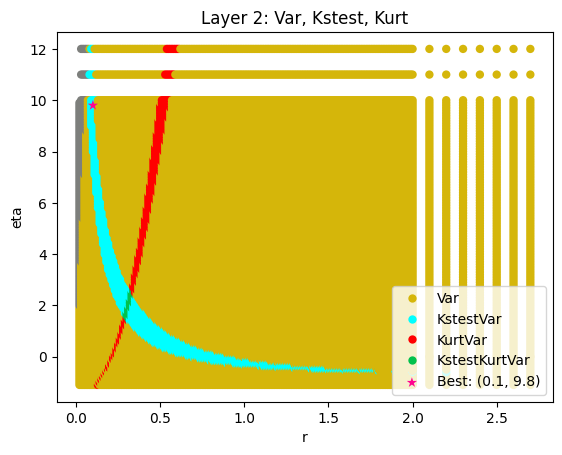

####
Layer  3


100%|██████████| 55966/55966 [00:26<00:00, 2144.04it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 12720, Without approximation : 12720.0


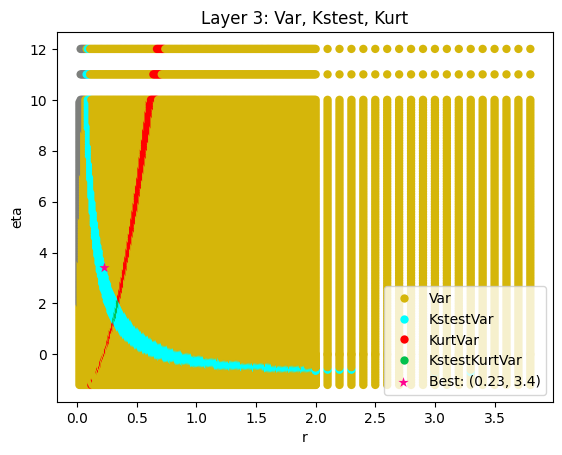

####
Layer  4


100%|██████████| 55966/55966 [01:38<00:00, 565.33it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 50880, Without approximation : 50880.0


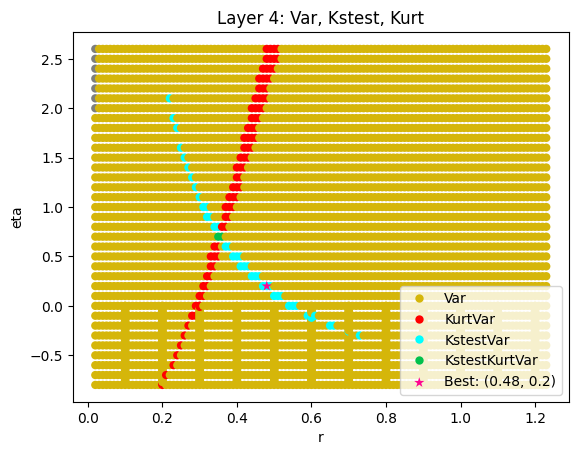

####
Layer  5


100%|██████████| 55966/55966 [03:10<00:00, 294.15it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 203520.0


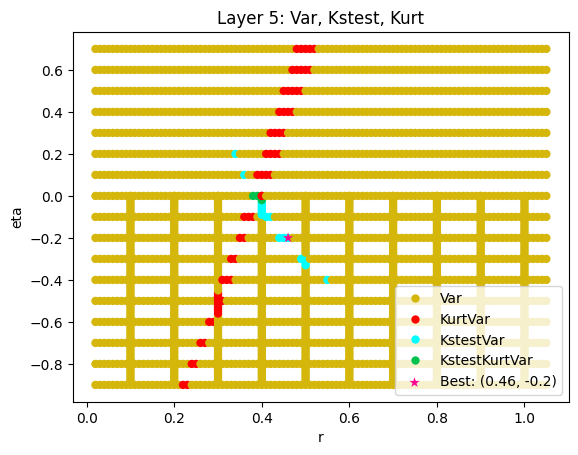

####
Layer  6


100%|██████████| 55966/55966 [03:14<00:00, 288.28it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 814080.0


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/2181848675.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


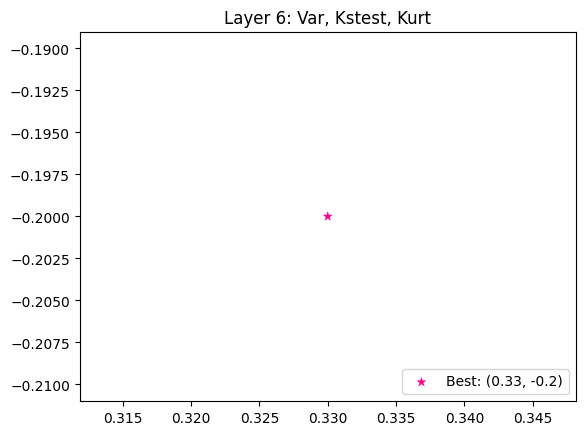

####
Layer  7


100%|██████████| 55966/55966 [03:10<00:00, 293.77it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 3256320.0


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/2181848675.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


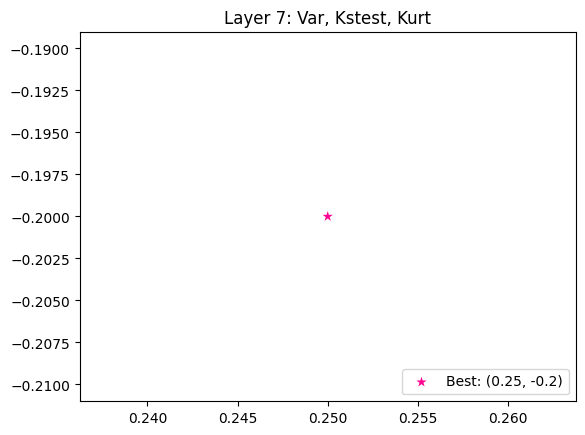

####
Layer  8


100%|██████████| 55966/55966 [03:10<00:00, 293.42it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/296407643.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  initial_scale = np.array(group_cdf_df[group_cdf_df["r"] ==  initial_param[0]][group_cdf_df["eta"] ==  initial_param[1]]["scale"])[0]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 13025280.0


/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/2181848675.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


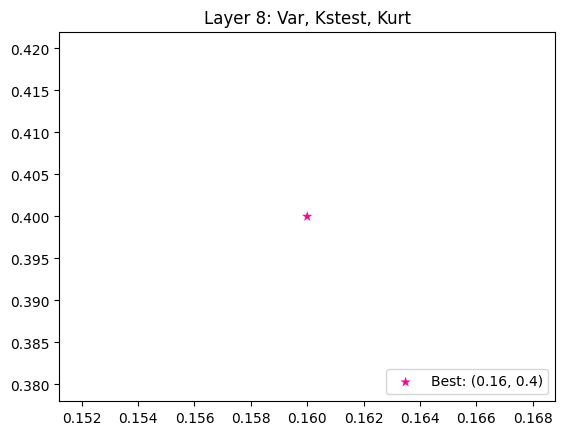

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,kstest_stat_initial,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,
2,1830.934600,1652.097700,2023.443800,2.933956,1.846394,4.126091,3180.0,0.10,9.8,3.660938e-18,0.016937,0.024030
3,587.781860,556.332100,620.660600,2.604501,2.026207,3.270645,12720.0,0.23,3.4,7.130501e-04,0.004775,0.012029
4,164.606740,154.984480,174.518840,3.278817,2.623241,4.093916,50880.0,0.48,0.2,8.935552e+00,0.004920,0.006018
5,37.863530,35.388520,40.433693,4.789257,3.843992,5.925406,203520.0,0.46,-0.2,2.703940e+00,0.002059,0.003010
6,7.493805,6.929792,8.083941,6.740130,5.245897,8.892210,814080.0,0.33,-0.2,6.127773e-02,0.003158,0.001505
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.25,-0.2,7.286756e-04,0.005270,0.000753
8,0.215883,0.196152,0.238341,12.285479,8.522737,23.484678,13025280.0,0.16,0.4,1.248581e-08,0.006035,0.000376


In [33]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param)
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

        # Optional: Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [46]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 3754.34it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:00<00:00, 1276.82it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 326.33it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 165.66it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 170.31it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 173.75it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:02<00:00, 176.49it/s]

Finding Minimum after computing 369 CDFs


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,initial_scale,...,best_r_eta0,best_scale_eta0,kstest_stat_eta0,best_r,best_eta,best_scale,kstest_stat_best,iter1_r,iter1_eta,kstest_stat_iter1
layer,,,,,,,,,,,,,,,,,,,,,
2,1830.934600,1652.097700,2023.443800,2.933956,1.846394,4.126091,3180.0,0.10,9.8,3.660938e-18,...,6.0,0.367890,0.328500,0.100,9.81,3.629908e-18,0.016915,0.100,9.81,0.016915
3,587.781860,556.332100,620.660600,2.604501,2.026207,3.270645,12720.0,0.23,3.4,7.130501e-04,...,5.9,0.367646,0.381017,0.229,3.45,6.323202e-04,0.004729,0.229,3.45,0.004729
4,164.606740,154.984480,174.518840,3.278817,2.623241,4.093916,50880.0,0.48,0.2,8.935552e+00,...,5.8,0.367382,0.423959,0.485,0.18,9.636337e+00,0.004817,0.485,0.18,0.004817
5,37.863530,35.388520,40.433693,4.789257,3.843992,5.925406,203520.0,0.46,-0.2,2.703940e+00,...,5.8,0.367382,0.455476,0.470,-0.23,3.144217e+00,0.001840,0.470,-0.23,0.001840
6,7.493805,6.929792,8.083941,6.740130,5.245897,8.892210,814080.0,0.33,-0.2,6.127773e-02,...,5.8,0.367382,0.475507,0.340,-0.24,8.382792e-02,0.002897,0.340,-0.24,0.002897
7,1.386997,1.272397,1.509542,9.084314,7.002164,12.550997,3256320.0,0.25,-0.2,7.286756e-04,...,5.8,0.367382,0.486987,0.256,-0.21,9.843622e-04,0.004651,0.256,-0.21,0.004651
8,0.215883,0.196152,0.238341,12.285479,8.522737,23.484678,13025280.0,0.16,0.4,1.248581e-08,...,5.8,0.367382,0.493742,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Optimization

In [35]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:837: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


Layer 2


100%|██████████| 400/400 [00:00<00:00, 4343.17it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]


Finding Minimum after computing 400 CDFs
Iter 1 layer 2 best parameters: ((0.1, 9.81), 0.016914780613256575)


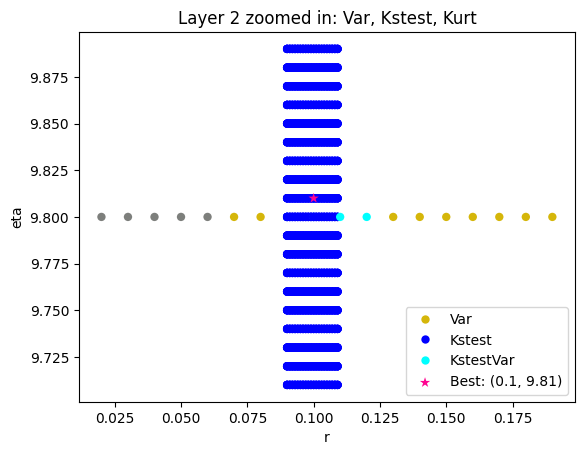

Layer 3
(0.222, 3.37), 50 of 441
(0.224, 3.45), 100 of 441
(0.227, 3.32), 150 of 441
(0.229, 3.4), 200 of 441
(0.231, 3.48), 250 of 441
(0.234, 3.35), 300 of 441
(0.236, 3.43), 350 of 441
(0.239, 3.3), 400 of 441


100%|██████████| 441/441 [00:00<00:00, 1205.49it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]


Finding Minimum after computing 441 CDFs
Iter 1 layer 3 best parameters: ((0.229, 3.45), 0.00472917893382907)


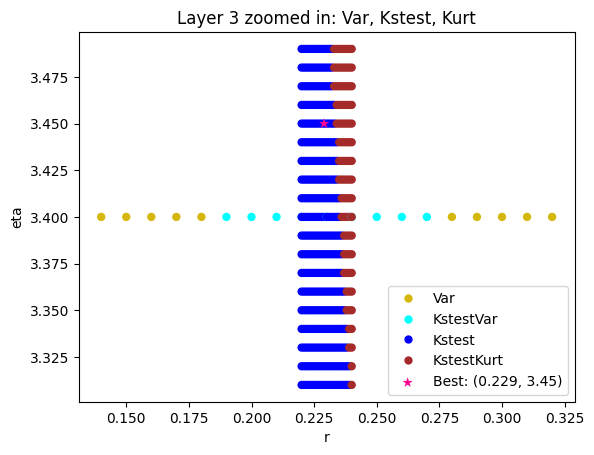

Layer 4
(0.472, 0.17), 50 of 441
(0.474, 0.25), 100 of 441
(0.477, 0.12), 150 of 441
(0.479, 0.2), 200 of 441
(0.481, 0.28), 250 of 441
(0.484, 0.15), 300 of 441
(0.486, 0.23), 350 of 441
(0.489, 0.1), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 343.60it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]


Finding Minimum after computing 441 CDFs
Iter 1 layer 4 best parameters: ((0.485, 0.18), 0.0048165575728161825)


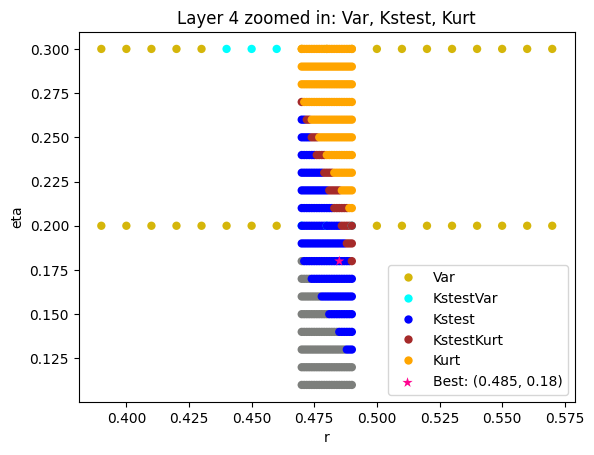

Layer 5
(0.452, -0.23), 50 of 441
(0.454, -0.15), 100 of 441
(0.457, -0.28), 150 of 441
(0.459, -0.2), 200 of 441
(0.461, -0.12), 250 of 441
(0.464, -0.25), 300 of 441
(0.466, -0.17), 350 of 441
(0.469, -0.3), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 182.88it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]


Finding Minimum after computing 441 CDFs
Iter 1 layer 5 best parameters: ((0.47, -0.23), 0.0018395393399718296)


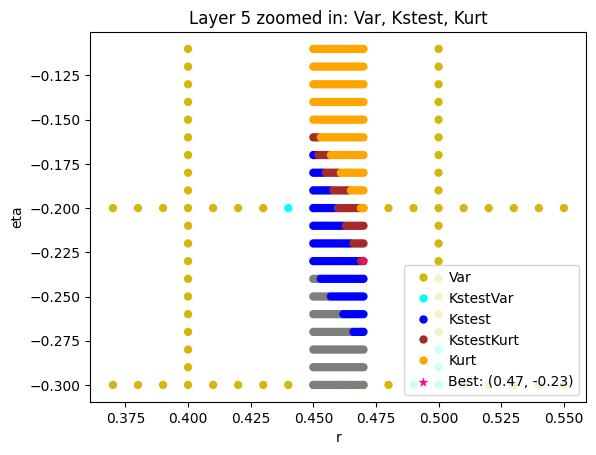

Layer 6
(0.322, -0.23), 50 of 441
(0.324, -0.15), 100 of 441
(0.327, -0.28), 150 of 441
(0.329, -0.2), 200 of 441
(0.331, -0.12), 250 of 441
(0.334, -0.25), 300 of 441
(0.336, -0.17), 350 of 441
(0.339, -0.3), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 186.76it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/2181848675.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 441 CDFs
Iter 1 layer 6 best parameters: ((0.34, -0.24), 0.0028965907684820325)


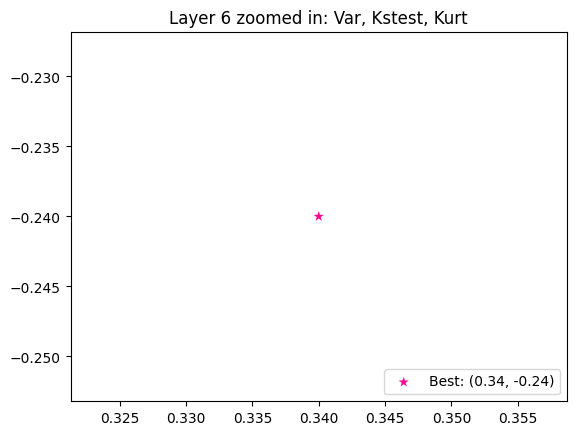

Layer 7
(0.242, -0.23), 50 of 441
(0.244, -0.15), 100 of 441
(0.247, -0.28), 150 of 441
(0.249, -0.2), 200 of 441
(0.251, -0.12), 250 of 441
(0.254, -0.25), 300 of 441
(0.256, -0.17), 350 of 441
(0.259, -0.3), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 165.08it/s]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/245435031.py:53: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  best_scale = np.array(temp_df[temp_df["r"] ==  best_param[0]][temp_df["eta"] ==  best_param[1]]["scale"])[0]
/var/folders/0c/5hhs4r6n7pnc4jcl295d7j_c0000gn/T/ipykernel_20341/2181848675.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  fig = sns.scatterplot(df, x='r', y='eta', hue='map', palette = fixed_palette, ax=ax, alpha=1, edgecolor='none')


Finding Minimum after computing 441 CDFs
Iter 1 layer 7 best parameters: ((0.256, -0.21), 0.00465089514877165)


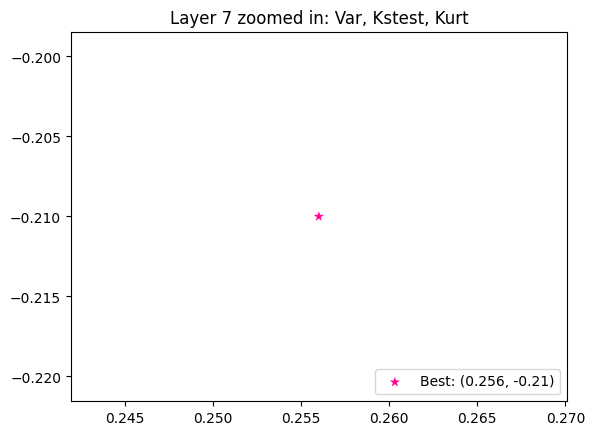

Layer 8


AssertionError: KS test failed

In [ ]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['variance'] = np.nan_to_num(temp_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)

                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales= temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

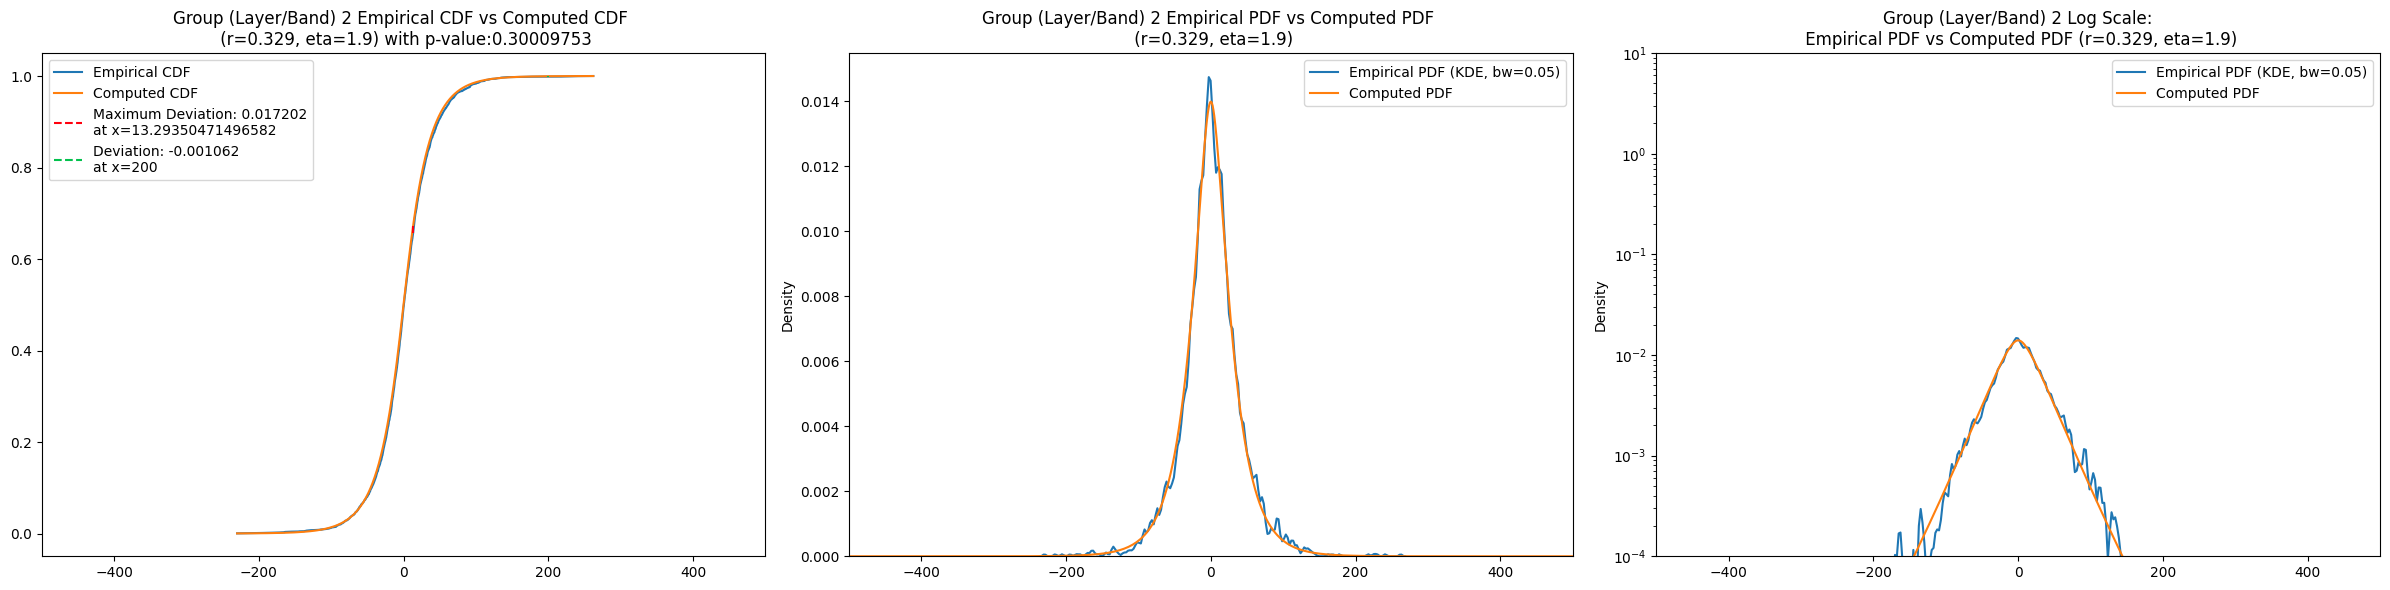

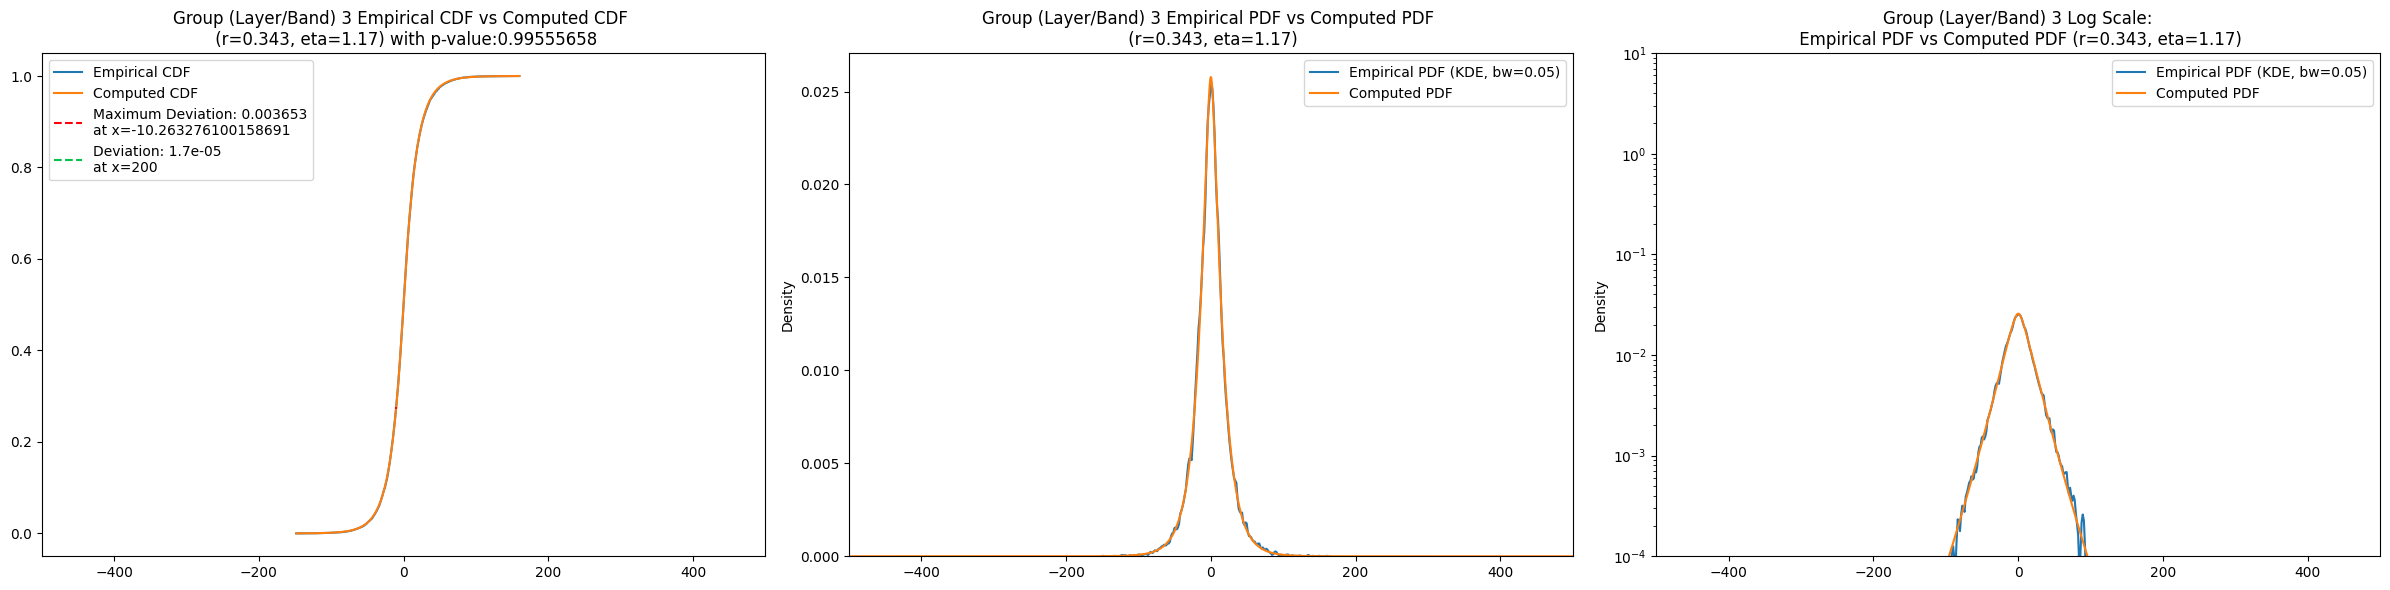

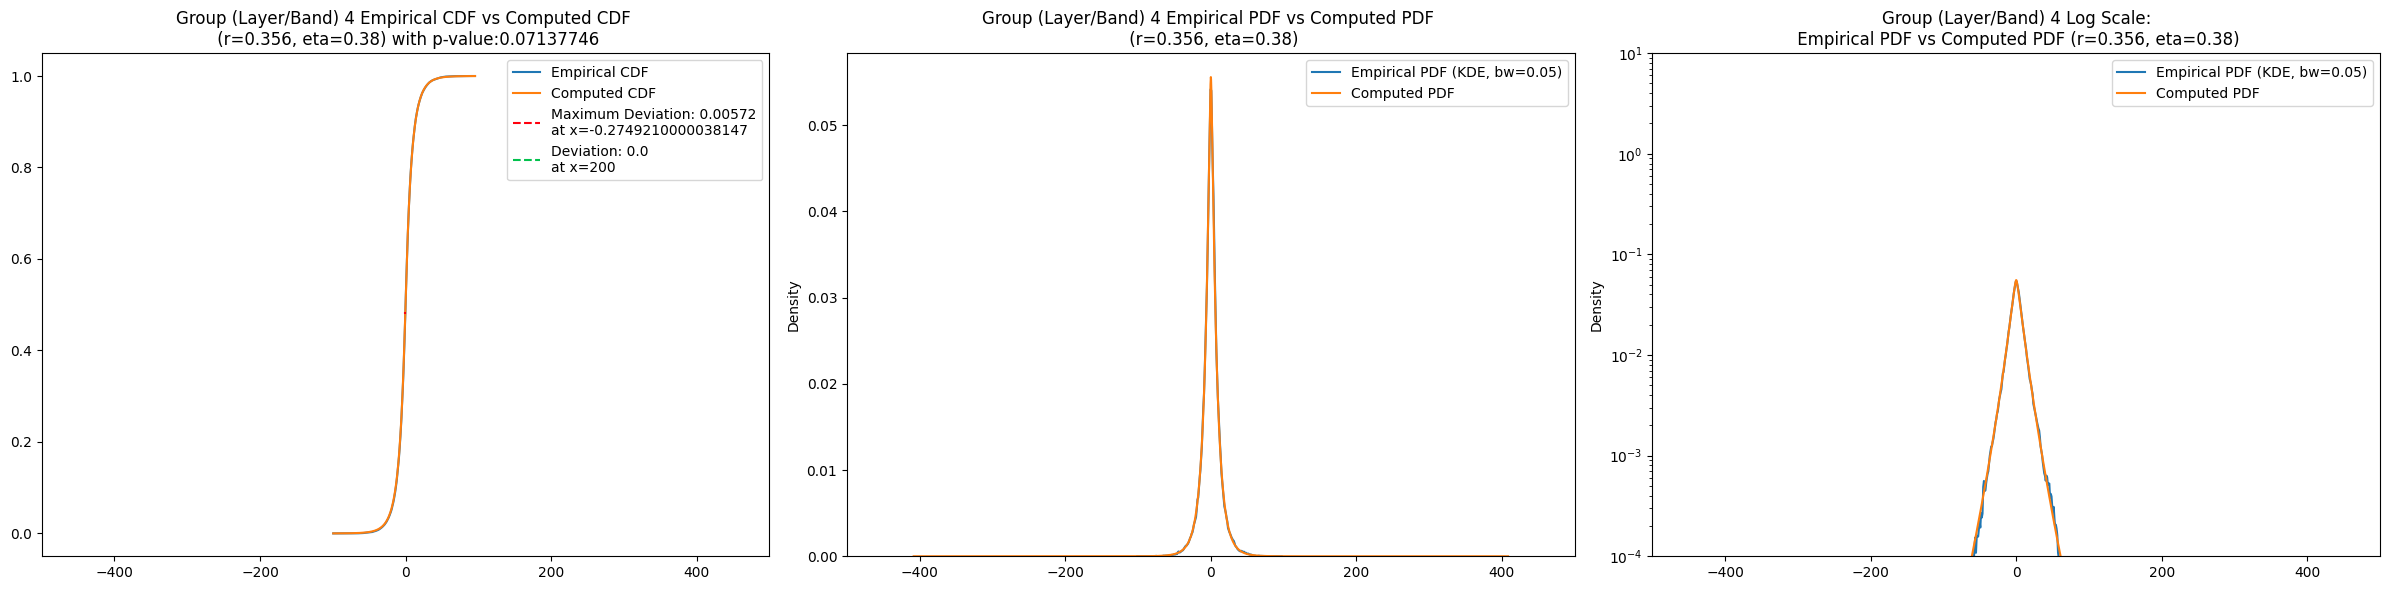

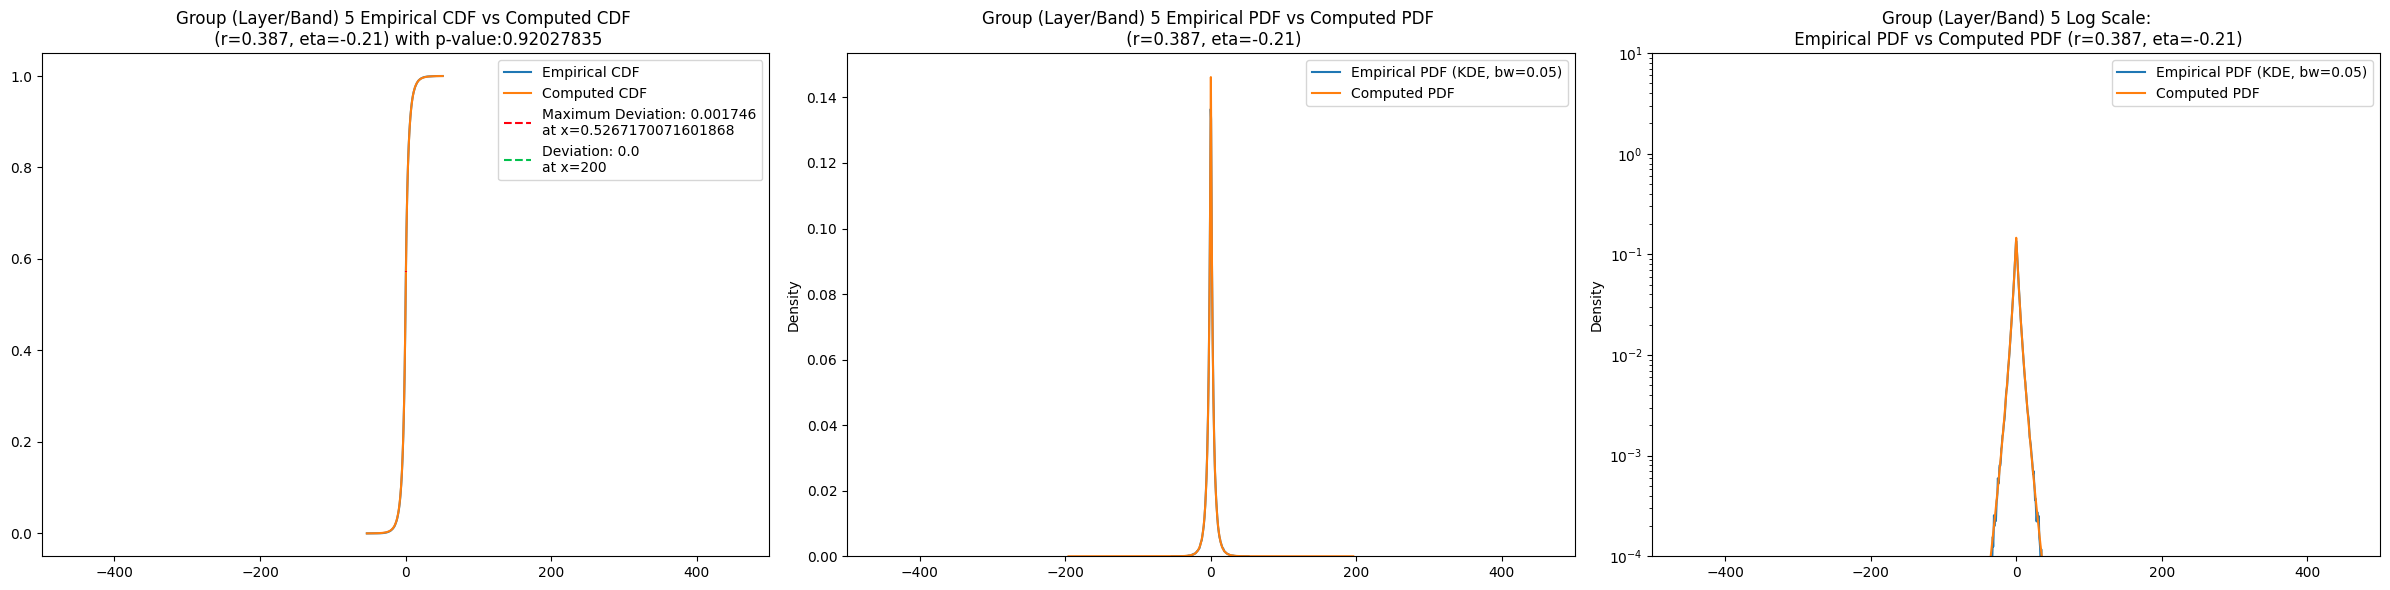

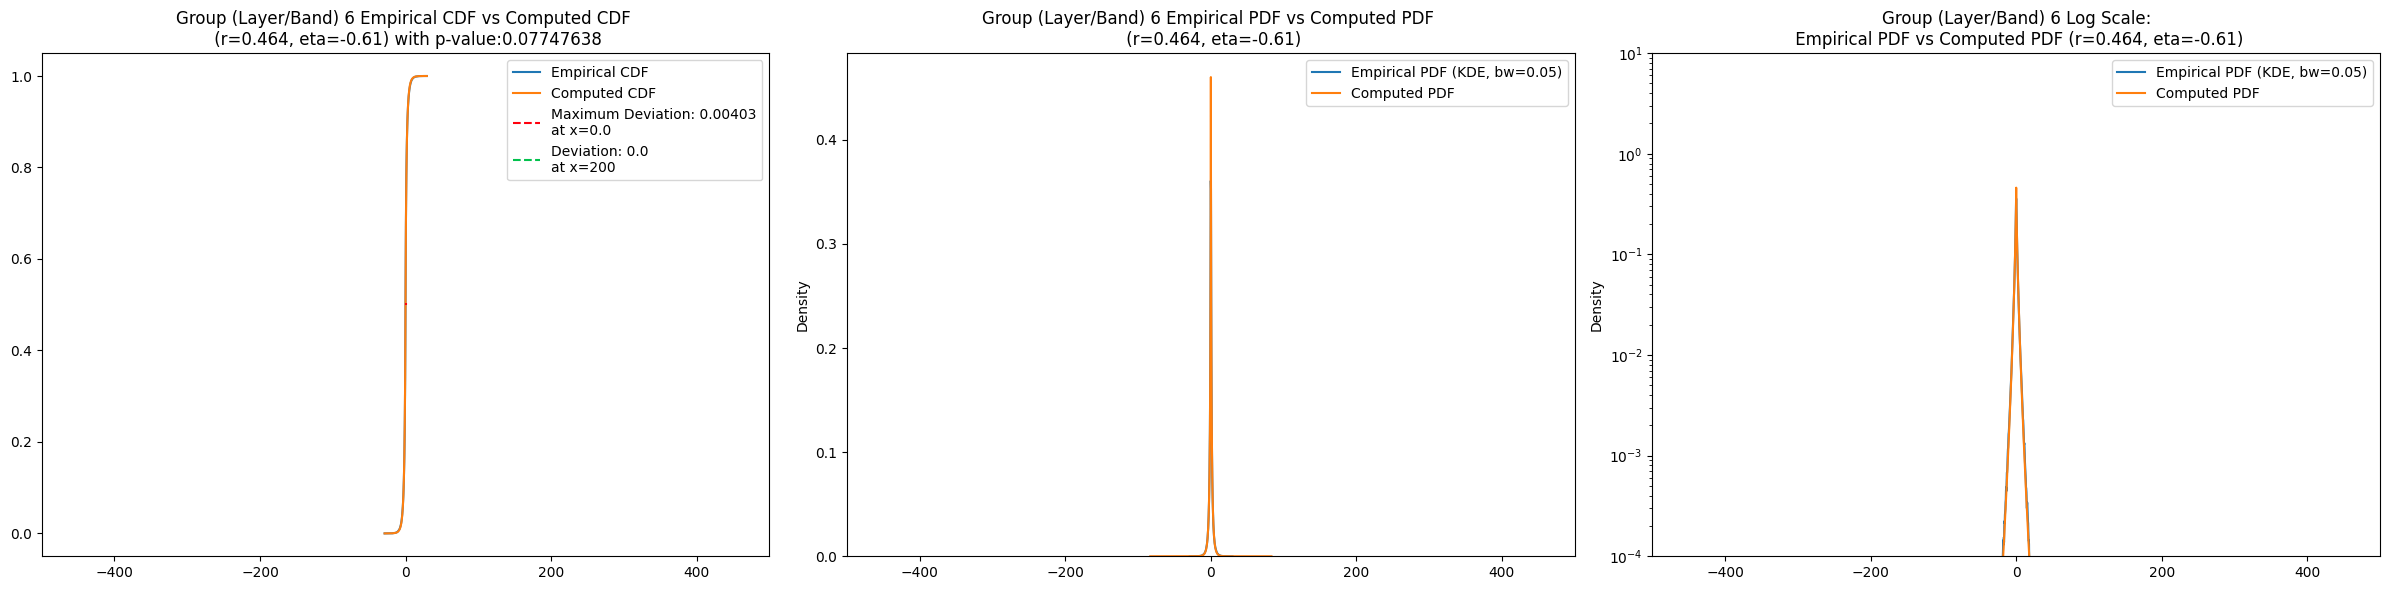

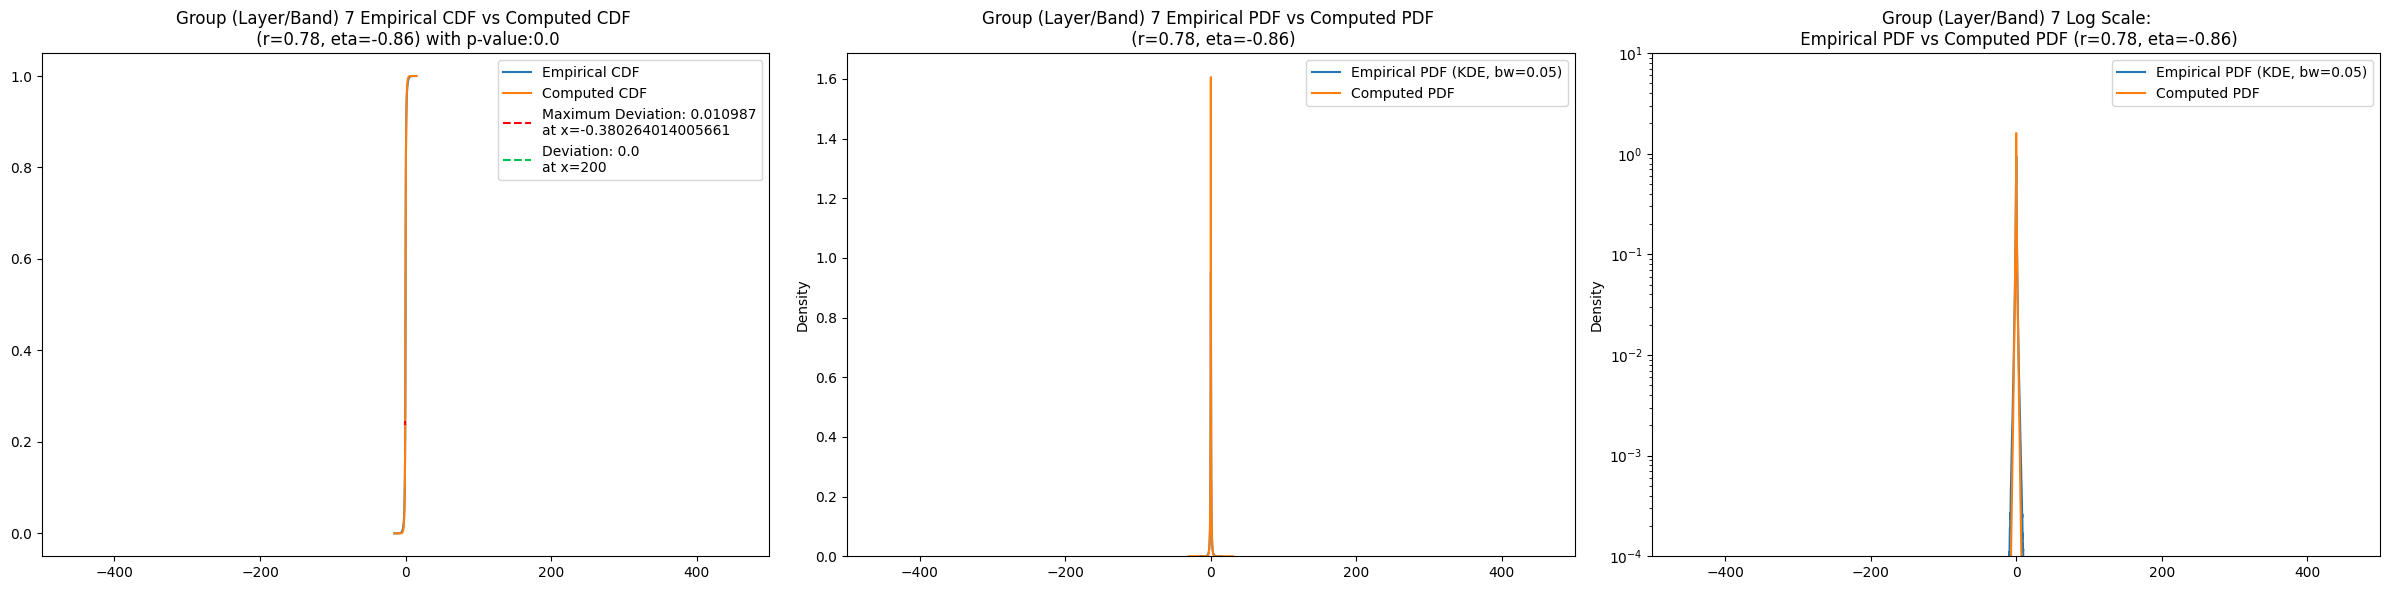

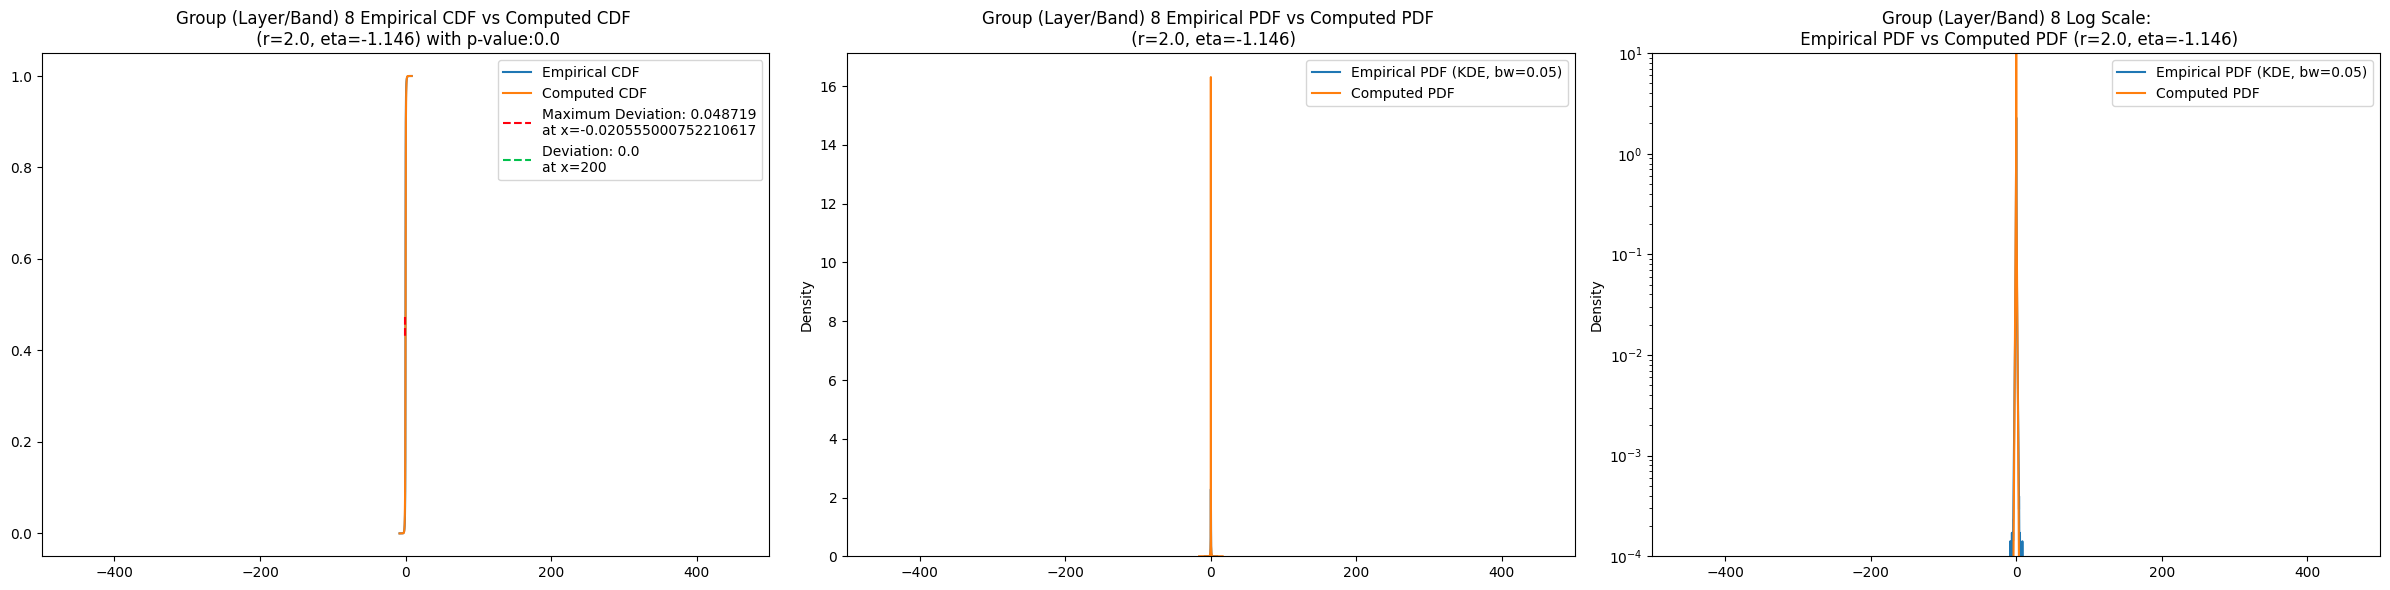

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1696.189600,1517.783900,1889.853600,3.796600,2.353942,5.295139,3180.0,0.33,1.90,0.019501,...,32.943400,0.032992,1.925360e-03,30.544800,0.022702,7.426860e-02,25.284700,0.018571,2.200210e-01,3.000975e-01
3,546.266700,515.087160,579.062300,3.272476,2.555443,4.080620,12720.0,0.34,1.10,0.004355,...,19.278300,0.026266,4.675180e-08,16.696100,0.008254,3.495940e-01,13.636900,0.011845,5.590880e-02,9.955566e-01
4,154.462460,145.019270,164.261180,3.816736,3.066599,4.774097,50880.0,0.35,0.30,0.007162,...,9.585560,0.032821,4.729710e-48,8.430870,0.006066,4.711630e-02,6.901150,0.009433,2.323800e-04,7.137243e-02
5,35.853176,33.392532,38.437500,5.541130,4.382674,6.967747,203520.0,0.39,-0.20,0.002787,...,4.246750,0.037929,7.965330e-255,3.722800,0.010595,2.845330e-20,3.004420,0.013621,3.143460e-33,5.640118e-01
6,7.102549,6.540381,7.693819,7.751813,5.927745,10.394491,814080.0,0.47,-0.60,0.004164,...,1.671520,0.047234,0.000000e+00,1.464350,0.019746,3.784750e-276,1.172610,0.021799,0.000000e+00,6.544400e-12
7,1.320503,1.204313,1.445969,10.719652,8.014826,15.655435,3256320.0,0.80,-0.85,0.011893,...,0.635292,0.054471,0.000000e+00,0.557946,0.027110,0.000000e+00,0.443521,0.027202,0.000000e+00,0.000000e+00
8,0.216768,0.195278,0.241856,15.263584,9.907603,31.192720,13025280.0,3.00,-1.15,0.049169,...,0.245468,0.054655,0.000000e+00,0.213079,0.029580,0.000000e+00,0.165991,0.030698,0.000000e+00,0.000000e+00


In [ ]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df#.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,initial_r,initial_eta,kstest_stat_initial,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,1696.189600,1517.783900,1889.853600,3.796600,2.353942,5.295139,3180.0,0.33,1.90,0.019501,...,32.943400,0.032992,1.925360e-03,30.544800,0.022702,7.426860e-02,25.284700,0.018571,2.200210e-01,3.000975e-01
3,546.266700,515.087160,579.062300,3.272476,2.555443,4.080620,12720.0,0.34,1.10,0.004355,...,19.278300,0.026266,4.675180e-08,16.696100,0.008254,3.495940e-01,13.636900,0.011845,5.590880e-02,9.955566e-01
4,154.462460,145.019270,164.261180,3.816736,3.066599,4.774097,50880.0,0.35,0.30,0.007162,...,9.585560,0.032821,4.729710e-48,8.430870,0.006066,4.711630e-02,6.901150,0.009433,2.323800e-04,7.137243e-02
5,35.853176,33.392532,38.437500,5.541130,4.382674,6.967747,203520.0,0.39,-0.20,0.002787,...,4.246750,0.037929,7.965330e-255,3.722800,0.010595,2.845330e-20,3.004420,0.013621,3.143460e-33,5.640118e-01
6,7.102549,6.540381,7.693819,7.751813,5.927745,10.394491,814080.0,0.47,-0.60,0.004164,...,1.671520,0.047234,0.000000e+00,1.464350,0.019746,3.784750e-276,1.172610,0.021799,0.000000e+00,6.544400e-12
7,1.320503,1.204313,1.445969,10.719652,8.014826,15.655435,3256320.0,0.80,-0.85,0.011893,...,0.635292,0.054471,0.000000e+00,0.557946,0.027110,0.000000e+00,0.443521,0.027202,0.000000e+00,0.000000e+00
8,0.216768,0.195278,0.241856,15.263584,9.907603,31.192720,13025280.0,3.00,-1.15,0.049169,...,0.245468,0.054655,0.000000e+00,0.213079,0.029580,0.000000e+00,0.165991,0.030698,0.000000e+00,0.000000e+00
